## Сборный проект. Игры

### Содержание

1. [Введение](#introduction)  
2. [Подготовка среды и получение общей информации](#environment)  
3. [Подготовка данных](#preparation)  
4. [Исследовательский анализ данных](#analyze)  
    4.1. [Данные по годам](#analyze_year)  
    4.2. [Продажи по платформам](#analyze_platforms)  
    4.3. [Построение прогноза на 2017 год](#analyze_forecast)  
    4.4. [Корреляция отзывов пользователей и критиков с продажами](#analyze_rating)  
    4.5. [Распределение по жанрам](#analyze_genre)  
5. [Портрет пользователя по регионам](#portret)
6. [Проверка гипотез](#hypothesis)  
    6.1. [Платформы Xbox One и PC](#hypothesis_platforms)  
    6.2. [Жанры Action и Sports](#hypothesis_genres)  
7. [Выводы и рекомендации](#conclusions)  

### 1. Введение <a id='introduction'></a>

**Заказчик:** интернет-магазине «Стримчик»  
**Цель:** выявить закономерности определяющие успешность игры  
**Объект исследования:** данные по играм до 2016 года

**Описание данных:**  
  
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### 2. Подготовка среды и получение общей информации <a id="environment"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_columns", None)

Запишу датасет в переменную *games*

In [2]:
try:
    games = pd.read_csv('games.csv')
except:
    games = pd.read_csv('/datasets/games.csv')

Получим первые пять строк датасета методом `head`. Также получим общую информацию методомами `info` и `describe`

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,"16,446.00","16,715.00","16,715.00","16,715.00","16,715.00","8,137.00"
mean,"2,006.48",0.26,0.15,0.08,0.05,68.97
std,5.88,0.81,0.50,0.31,0.19,13.94
min,"1,980.00",0.00,0.00,0.00,0.00,13.00
25%,"2,003.00",0.00,0.00,0.00,0.00,60.00
50%,"2,007.00",0.08,0.02,0.00,0.01,71.00
75%,"2,010.00",0.24,0.11,0.04,0.03,79.00
max,"2,016.00",41.36,28.96,10.22,10.57,98.00


В датасете 11 колонок и 16715 строк. Имеются пропущенные значения. Год выпуска имеет формат *float*. Необходимо перевести его к формату *int*. Также пользовательский рейтинг имеeт формат *object*. Нужно будет поработать с этим

### 3. Подготовка данных <a id='preparation'></a>

#### Приведение названия столбцов к нижнему регистру

In [6]:
games.columns = ['name',
                 'platform',
                 'year_of_release',
                 'genre',
                 'na_sales',
                 'eu_sales',
                 'jp_sales',
                 'other_sales',
                 'critic_score',
                 'user_score',
                 'rating'
                ]

#### Заполнение пропусков

Пойдем по порядку и начнем наименования. Но сначала напишем две функции. Первая будет фильтровать датасет по пропускам в колонке и выдавать значение, чтобы можно было изучить визуально. Возможно так будет легче определить, что делать с пропусками. Ну и вторая функция покажет количество пропусков

In [7]:
def show_na(column):
    result = games.loc[games[column].isnull()]
    return result.head()

In [8]:
def qty_na(column):
    count = games.loc[games[column].isnull()]
    return len(count[column])

In [9]:
show_na('name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,"1,993.00",NaN,1.78,0.53,0.00,0.08,nan,NaN,NaN
14244,NaN,GEN,"1,993.00",NaN,0.00,0.00,0.03,0.00,nan,NaN,NaN


In [10]:
qty_na('name')

2

Такие пропуски никак не заполнить. Две строки погоды не сделают, так что лучше их удалить.

In [11]:
games.dropna(subset=['name'], inplace=True)

In [12]:
show_na('year_of_release')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,nan,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E
377,FIFA Soccer 2004,PS2,nan,Sports,0.59,2.36,0.04,0.51,84.00,6.4,E
456,LEGO Batman: The Videogame,Wii,nan,Action,1.80,0.97,0.00,0.29,74.00,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,nan,Fighting,1.57,1.02,0.00,0.41,nan,NaN,NaN
609,Space Invaders,2600,nan,Shooter,2.36,0.14,0.00,0.03,nan,NaN,NaN


In [13]:
qty_na('year_of_release')

269

Выглядит будто для некоторых игр годы выпуска имеется в названии. Посмотрим все наименования с пропущенным годом выпуска

In [14]:
games.loc[games['year_of_release'].isnull()]['name'].unique()

array(['Madden NFL 2004', 'FIFA Soccer 2004',
       'LEGO Batman: The Videogame', 'wwe Smackdown vs. Raw 2006',
       'Space Invaders', 'Rock Band',
       "Frogger's Adventures: Temple of the Frog",
       'LEGO Indiana Jones: The Original Adventures', 'Call of Duty 3',
       'Call of Duty: Black Ops', 'Triple Play 99', 'Adventure', 'Combat',
       'LEGO Harry Potter: Years 5-7', 'NASCAR Thunder 2003',
       'Hitman 2: Silent Assassin', 'Legacy of Kain: Soul Reaver',
       'Donkey Kong Land III', 'Air-Sea Battle', 'Suikoden III',
       'Wheel of Fortune', 'Yakuza 4', 'Namco Museum', 'Rhythm Heaven',
       'The Lord of the Rings: War in the North', 'Madden NFL 07',
       'MLB SlugFest 20-03', 'Shaun White Snowboarding',
       'PES 2009: Pro Evolution Soccer', 'WarioWare: Twisted!',
       'Madden NFL 11', 'Test Drive Unlimited 2',
       'The Chronicles of Narnia: The Lion, The Witch and The Wardrobe',
       'Monster Hunter 2', 'Metal Gear Solid 2: Substance',
       'Advanc

Можно конечно попытаться вытащить год для некоторых игр, у которых год игры имеется в названии. Их немного но они есть. Посмотрю какой процент с пропущенным годом от общего числа строк, чтобы знать стоит ли это потраченного времени

In [15]:
print(qty_na('year_of_release') / len(games))

0.016095255190570215


Полтора процента. Думаю, лучше заполнить нулями. А во время анализа буду исключать нулевые года из выборки. 1,6% на общие результаты не повлияют

In [16]:
games['year_of_release'] = games['year_of_release'].fillna(0)

Ну и переведем формате года к числовому `int64`. Год все таки целое число

In [17]:
games['year_of_release'] = games['year_of_release'].astype('int64')

Далее на очереди рейтинг критиков. Посмотрим на данные

In [18]:
show_na('critic_score')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,nan,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,nan,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,nan,NaN,NaN


In [19]:
qty_na('critic_score')

8576

Пропусков очень много. Более 50% игр не имеют рейтинга критиков. Это очень много. Заполнить их медианой, средней или модой будет неверно, так как это очень сильно исказит результаты исследования. Лучшим вариантом тут является оставить их в формате `nan`. Так они не повлияют на расчеты

Теперь посмотрим рейтинг пользователей

In [20]:
show_na('user_score')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,nan,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,nan,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,nan,NaN,NaN


In [21]:
qty_na('user_score')

6699

Тоже не мало. Стоит просто привести к формату `int64` и оставить так как есть по той же самой причине, что была для рейтинга критиков. Но пока это не представляется возможным, потому что в документации сказано, что в колонке имеются данные записанные как *tbd*. Это не позволит привести к числовому формату.  
Это аббревиатура означает *to be defined* и применяется в том случае, когда количества отзывов не достаточно для определения рейтинга. К примеру на сайте metacritic отображается только тот рейтинг в котором имеется как минимум 4 отзыва. Лучшим вариантом с такого рода строками является приведение их к формату `nan`. Для этого воспользуемся методом `apply` и lambda функцией

In [22]:
games.loc[games['user_score'] == 'tbd'].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.00,0.66,nan,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.00,0.54,61.00,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.00,0.27,nan,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.00,0.20,71.00,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,0,Adventure,2.15,0.18,0.00,0.07,73.00,tbd,E


In [23]:
games['user_score'] = games['user_score'].apply(lambda x: np.nan if x == 'tbd' else x)

In [24]:
games.loc[games['user_score'] == 'tbd'].head() #проверяю сработало ли

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Теперь переведем к числовому формату

In [25]:
games['user_score'] = games['user_score'].astype('float64')

Замечательно! Осталась последняя колонка с рейтингом от организации ESRB. Посмотрим на пропуски

In [26]:
show_na('rating')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,nan,nan,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,nan,nan,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,nan,nan,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,nan,nan,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,nan,nan,NaN


In [27]:
qty_na('rating')

6764

Снова пропусков очень много. Удалить их не получится. Также заполнить их также не получится. Можно присвоить им категорию `unclassified` или сокращенно `unc`. Думаю,  это лучший вариант в данной ситуации

In [28]:
games['rating'] = games['rating'].fillna('unc')

Все данные обработали. Также добавлю в конце общую сумму по продажам в колонку *total*

In [29]:
games['total'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

Также добавлю колонку в которой будут прологарфмированные данные по колонке *total*. Это позволит получать более наглядные диаграммы. Метод я подсмотрел в одном из вебиноров по анализу данных. Логарифм сжимает данные, сокращая расстояния между значениями, при этом не меняя структуру массива, что позволяет уйти от выбросов. В данном случае данный метод более чем оправдан, потому что распределение по продажам сгруппировано в левой части, но при этом имеются выбросы, которые уходят далеко вправо, что повлияет на качество отображения диаграмм. А удалять эти данные или делать срез будет неправильно. Ведь в таком случае потеряются очень важные данные. Удачные игры имеют феноменальные продажи и это никакая не ошибка в данных, а факт

In [30]:
games['total_log'] = games['total'].apply(lambda x: np.log(x))

In [31]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total,total_log
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54,4.41
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,nan,nan,unc,40.24,3.69
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52,3.57
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77,3.49
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,nan,nan,unc,31.38,3.45


#### Выводы после обработки данных

In [32]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16713 non-null  object 
 11  total            16713 non-null  float64
 12  total_log        16713 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 1.8+ MB


In [33]:
games.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total,total_log
count,"16,713.00","16,713.00","16,713.00","16,713.00","16,713.00","8,137.00","7,590.00","16,713.00","16,713.00"
mean,"1,974.19",0.26,0.15,0.08,0.05,68.97,7.13,0.53,-inf
std,252.57,0.81,0.50,0.31,0.19,13.94,1.50,1.55,nan
min,0.00,0.00,0.00,0.00,0.00,13.00,0.00,0.00,-inf
25%,"2,003.00",0.00,0.00,0.00,0.00,60.00,6.40,0.06,-2.81
50%,"2,007.00",0.08,0.02,0.00,0.01,71.00,7.50,0.17,-1.77
75%,"2,010.00",0.24,0.11,0.04,0.03,79.00,8.20,0.47,-0.76
max,"2,016.00",41.36,28.96,10.22,10.57,98.00,9.70,82.54,4.41


Удалил игры, у которых небыло наименования. Помимо этого не было ни жанра, ни рейтингов. Тем более было всего две таких строчки. Пользы от них никакой.  
  
Привел год к целочисленному формату и заполнил пропуски нулями, так как год для анализа не нужен.  
  
Рейтинги критиков и пользователей пропущенные значения не стал как-либо обрабатывать, потому что не имеется более менее приемлимого способа их заполнения. Привел пользовательский рейтинг к числовому формату.  
  
В рейтинге для пропусков присвоил пропускам категорию `unc`.  
  
Добавил колонку *total* в которой суммируются сборы со всех регионов. И также добавил колонку *total_log*, чтобы диаграммы были понятней
  
Стоит сообщить инженерам по сбору данных о найденных мною пропусках и ошибках, чтобы они постарались их устранить. Возможные причины пропусков - ошибка программы, которым занималась сбором данных. Вероятно критерии, по которым заполнялся рейтинг из открытых источников был некорректен, что привело к пропускам. То же самое и по году выпуска

### 4. Исследовательский анализ данных <a id='analyze'></a>

#### 4.1. Данные по годам <a id='analyze_year'></a>

Посмотрим сколько игр выпускалось в разные годы. Для этого составлю сводную таблицу по годам. И на основе нее построю столбчатую диаграмму. Также нужно не забыть, что у нас были пропуски, которые я заполнил нулями. Лучше исключить эти данные

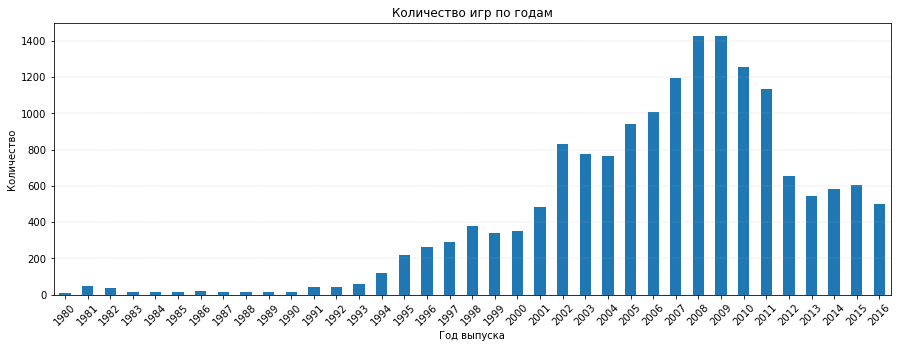

In [34]:
games.loc[
    games['year_of_release'] != 0
].pivot_table(
    index = 'year_of_release',
    values = 'name',
    aggfunc = 'count'
).plot(
    kind='bar',
    figsize = (15, 5),
    title = 'Количество игр по годам',
    legend = False,
    xlabel = 'Год выпуска',
    ylabel = 'Количество',
    rot = 45
).grid(linestyle='-.', linewidth=0.25, axis='y')
plt.show()

In [35]:
games.loc[
    games['year_of_release'] != 0
].pivot_table(
    index = 'year_of_release',
    values = 'name',
    aggfunc = 'count'
).describe()

,name
count,37.00
mean,444.43
std,451.60
min,9.00
25%,36.00
50%,338.00
75%,762.00
max,"1,427.00"


В датасете представлены игры за 37 лет - от 1980 до 2016 включительно. Самыми урожайными на игры были 2008 и 2009 годы, когда было более 1400 игр в каждый год. В среднем издавалось 444 игры. Медиана при этом 338 игр. Данные до 1990 года не важны, так как игр выпускалось очень мало.

#### 4.2. Продажи по платформам <a id='analyze_platforms'></a>

Построю сводную таблицу для 10 самых успешных платформ

In [36]:
games.pivot_table(
    index='platform',
    values='total',
    aggfunc='sum'
).sort_values(by='total', ascending=False).head(10)

,total
platform,
PS2,"1,255.77"
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


Самая успешная платформа - это PlayStation 2. А теперь для 5 самых успешных платформ построю распределение по годам. Для этого напишу функцию, которая на входе будет получать наименование платформы и выдавать график с распределением выручки по годам и срок существования платформы.

In [37]:
def platform_revenue(platform):
    games.loc[
        (games['year_of_release'] != 0)
        &
        (games['platform'] == platform)
    ].pivot_table(
        index = 'year_of_release',
        values = 'total',
        aggfunc = 'sum'
    ).plot(
        kind='bar',
        figsize=(10, 5),
        legend = False,
        title = 'Распределение выручки по годам для платформы {}'.format(platform),
        rot = 0,
        xlabel = 'Год выпуска',
        ylabel = 'Млн. копий',
    ).grid(linestyle='-.', linewidth=0.25, axis='y')
    plt.show()
    
    years = len(games.loc[(games['year_of_release'] != 0) & (games['platform'] == platform)]['year_of_release'].unique())
    print('Срок существования платформы', platform, years, 'лет')
    

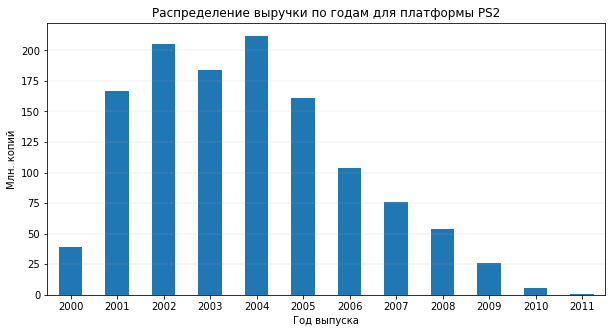

Срок существования платформы PS2 12 лет


In [38]:
platform_revenue('PS2')

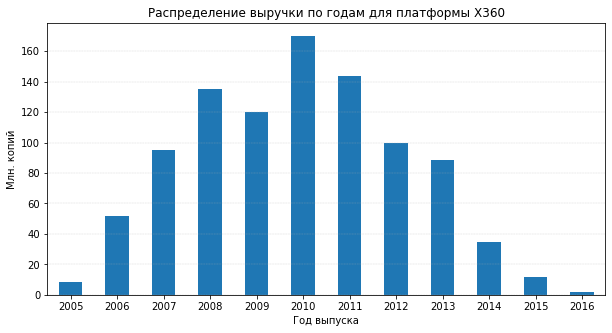

Срок существования платформы X360 12 лет


In [39]:
platform_revenue('X360')

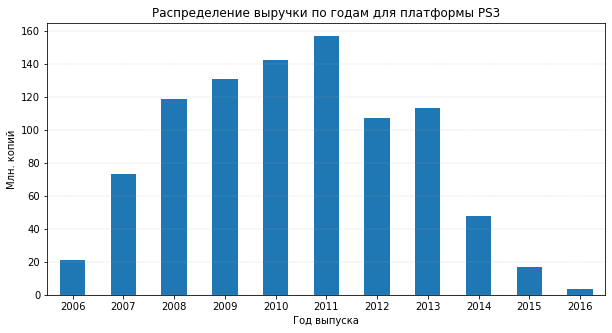

Срок существования платформы PS3 11 лет


In [40]:
platform_revenue('PS3')

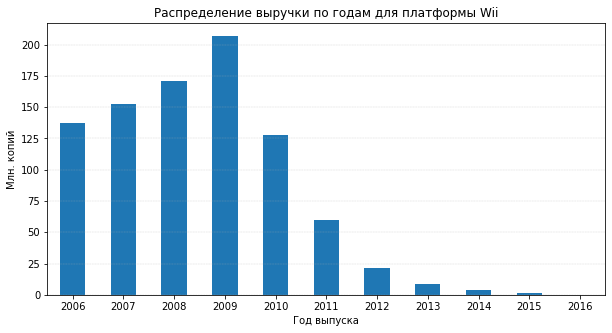

Срок существования платформы Wii 11 лет


In [41]:
platform_revenue('Wii')

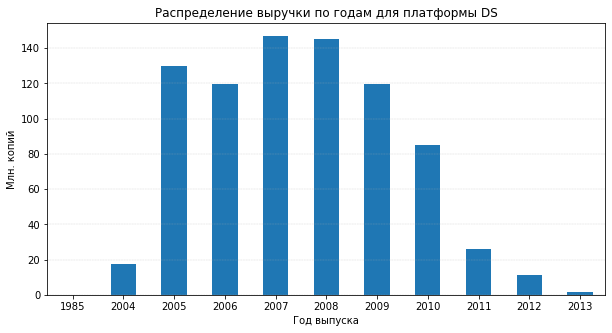

Срок существования платформы DS 11 лет


In [42]:
platform_revenue('DS')

Для платформы DS имеется артефакт в 1985 году. Без него срок существования платформы 10 лет.

In [43]:
games.loc[
    (games['platform'] == 'DS')
    &
    (games['year_of_release'] == 1985)
]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total,total_log
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.00,0.00,0.02,0.00,nan,nan,unc,0.02,-3.91


Думаю, в 1985 году существовала платформа с таким же наименованием. Но она была не очень популярна

**Вывод по подразделу разделу**  
  
В среднем платформы живут около 11 лет. Максимальная выручка приходится на середину срока существования платформы.

#### 4.3. Построение прогноза на 2017 год <a id='analyze_forecast'></a>

Как выяснилось ранее платформы в среднем живут 11 лет. Для прогноза буду использовать выборку из предыдущих 4 лет. Так я захвачу самые актуальные данные и увижу тренды. Особых изменений за такой промежуток времени произойти не должно, поэтому выводы будут правдоподобными. Создам срез актуальных данных. При этом нужно учитывать, что для 2016 года данные неполные, поэтому снижение тренда в 2016 году можно частично объяснять этим

In [44]:
milestone_year = games['year_of_release'].max() - 4 #переменная с годом от которого начинать отсчет

In [45]:
actual_games = games.query(
    'year_of_release > @milestone_year'
)

Построю график с платформами и проданными копиями игр, чтобы понять в каком состоянии каждая из них.

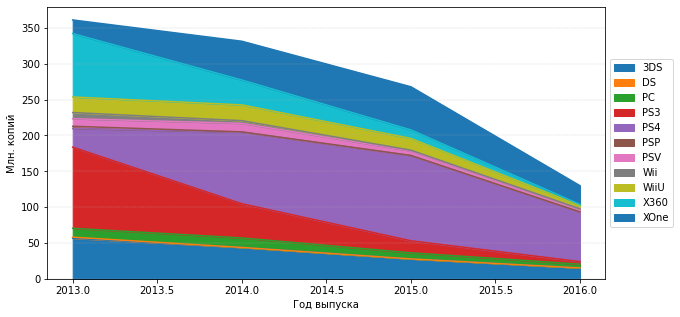

In [46]:
actual_games.pivot_table(
    index = 'year_of_release',
    columns = 'platform',
    values = 'total',
    aggfunc = 'sum'
).plot(
    kind='area',
    stacked=True,
    figsize=(10, 5),
    legend = 'reverse',
    rot = 0,
    xlabel = 'Год выпуска',
    ylabel = 'Млн. копий',
)
plt.grid(linestyle='-.', linewidth=0.25, axis='y')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [47]:
actual_games.pivot_table(
    index = 'year_of_release',
    columns = 'platform',
    values = 'total',
    aggfunc = 'sum',
    fill_value=0
)

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,0.00,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,0.00,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,0.00,5.25,3.60,69.25,0.00,4.25,0.18,4.60,1.52,26.15


Как видно из графика ранее популярные платформы как X360, PS3 начинают "затухать". При этом PS4 набирает популярность. Для нее выпускается много игр. XOne и 3DS также имеют хорошие продажи. Но в целом наблюдается тенденция к падению роста продаж игр для всех платформ. Связано это может быть с тем, что за 2016 год данные не полные. PC очень долгоживущая платформа и в среднем имеет неплохие продажи на протяжении всего периода. Итого имеются три лидера: PS4, XOne и 3DS

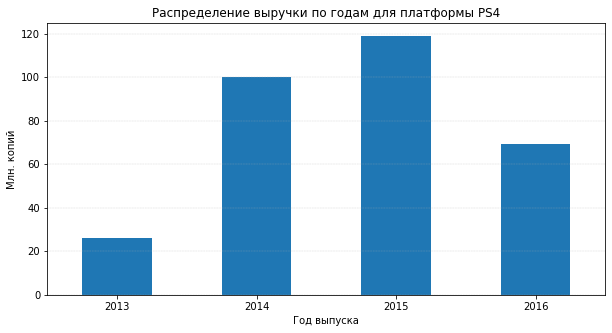

Срок существования платформы PS4 4 лет


In [48]:
platform_revenue('PS4')

PS4 платформа отнсоительно молодая. Если она повторит усехи своих предшественниц, то стоит уделить ей внимание.

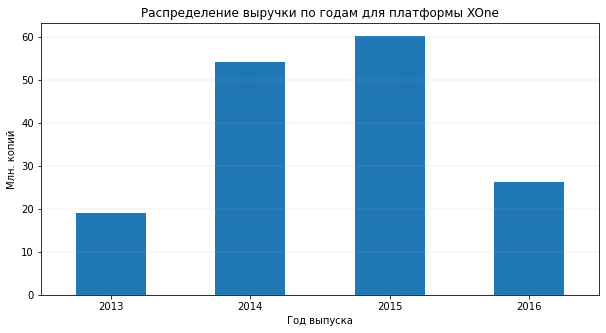

Срок существования платформы XOne 4 лет


In [49]:
platform_revenue('XOne')

Конкурирующая с PS4 платформа XOne также начинает набирать обороты. Хотя ее продажи отнсоительно конкурента не так высоки

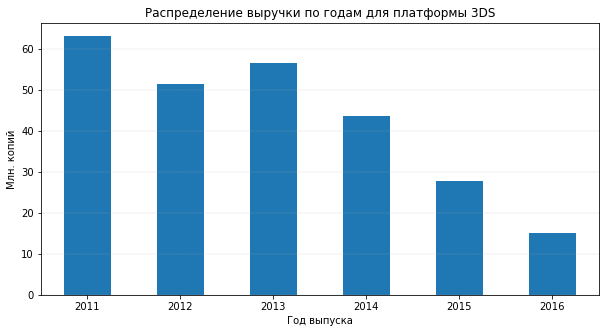

Срок существования платформы 3DS 6 лет


In [50]:
platform_revenue('3DS')

Платформа очень хорошо стартовала в 2011 году, но в целом продажи повторяют конънктуру рынка и наблюдается спад. Также вероятен закат платформы в ближайшие пару лет

Теперь попробуем получить ящик с усами для самых успешных платформ актуального периода. Конкурентов поставлю рядом, чтобы видеть различия. Ну и также я прибавлю к ним платформу PC, так она долгожитель и пользуется популярностью у геймеров возможностями апгрейда, что недоступно другим платформам

In [51]:
actual_games.pivot_table(
    index = 'platform',
    values = 'total',
    aggfunc = 'sum'
).sort_values(
    by='total',
    ascending = False
).head(10)

,total
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99
Wii,13.66


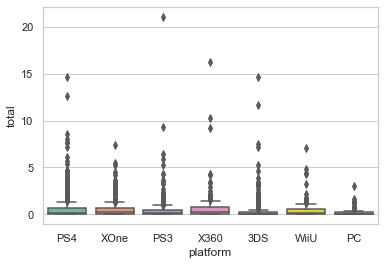

In [52]:
sns.set_theme(style="whitegrid")
sns.boxplot(
    data=actual_games,
    x='platform',
    y='total',
    order=['PS4', 'XOne', 'PS3', 'X360', '3DS', 'WiiU', 'PC'],
    palette='Set2',
    whis=1
)
plt.show()

Не очень наглядно. Воспользуемся нашей колонкой с прологарифмированными данными

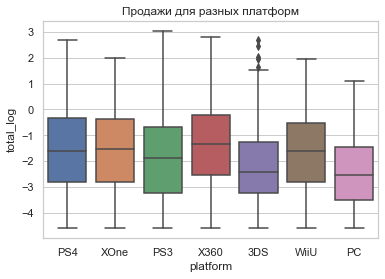

In [53]:
sns.boxplot(
    data=actual_games,
    x='platform',
    y='total_log',
    order=['PS4', 'XOne', 'PS3', 'X360', '3DS', 'WiiU', 'PC']
)
plt.title('Продажи для разных платформ')
plt.show()

Так лучше!  
  
Как видно из диаграммы. Платформы X360 более успешна чем PS3. Медианы и межквартильные размахи у PS3 ниже, но усы дальше, что говорит о наличии игр-хитов. Если рассматривать следующие итерации конкурентов PS4 и XOne то тут пока все ровно. Медиана чуть выше у XOne, но усы у PS4 выше. Но все же результаты не сильно отличаются. Для других платформ игр выпускается меньше, соответственно и продажи у них меньше, но все же у каждой существуют такие, которые становятся очень популярными. Например, об этом говорят выбросы у приставки 3DS.

#### 4.4. Корреляция отзывов пользователей и критиков с продажами <a id='analyze_rating'></a>

Чтобы проследить эту корреляцию, напишу функцию, которая на входе будет брать платформу и выдавать две диаграммы рассеивания где в одной будут отзывы критиков, а для другой пользователей. В диаграммах распределения я буду использовать колонку *total_log*, а для получения коэффициента корреляции колонку *total*

In [54]:
def cor_rating_sales(platform):
    
    #делаю срез по указанной платформе
    data = actual_games.loc[actual_games['platform'] == platform]
    
    #вывожу диаграмму распределения для оценок критиков и пользователей
    g = sns.PairGrid(data, y_vars=["total_log"], x_vars=["critic_score", "user_score"], height=4)
    g.map(sns.regplot)
    g.fig.suptitle('Зависимости продаж от оценок для платформы {}'.format(platform))
    plt.show()
    
    #Также покажу коэффициенты корреляцияя для обеих оценок
    critics = data.corr()['critic_score'].iloc[7]
    users = data.corr()['user_score'].iloc[7]
    print('Коэффициент корреляции между оценками критиков и продажами для платформы', platform, 'составлявет {:.2f}'.format(critics))
    print('Коэффициент корреляции между оценками пользователей и продажами для платформы', platform, 'составлявет {:.2f}'.format(users))

Сначала проверим платформу X360

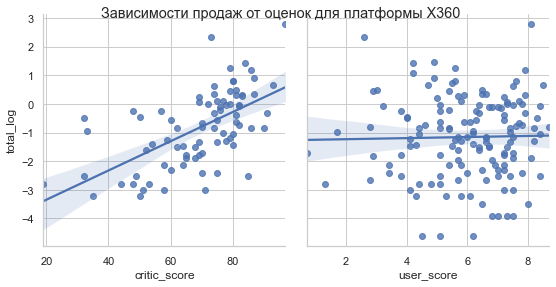

Коэффициент корреляции между оценками критиков и продажами для платформы X360 составлявет 0.35
Коэффициент корреляции между оценками пользователей и продажами для платформы X360 составлявет -0.01


In [55]:
cor_rating_sales('X360')

Теперь посмотрим на платформу PS3

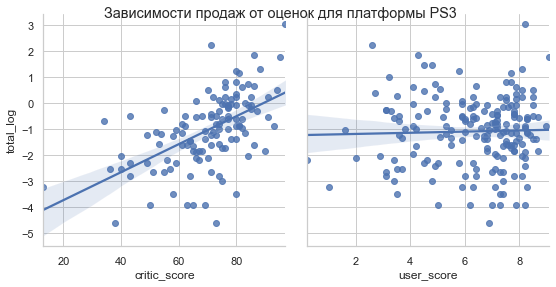

Коэффициент корреляции между оценками критиков и продажами для платформы PS3 составлявет 0.33
Коэффициент корреляции между оценками пользователей и продажами для платформы PS3 составлявет 0.00


In [56]:
cor_rating_sales('PS3')

Также посмотрим XOne

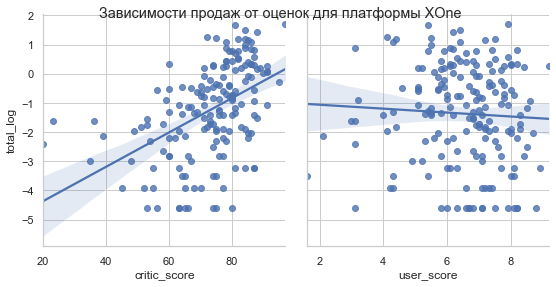

Коэффициент корреляции между оценками критиков и продажами для платформы XOne составлявет 0.42
Коэффициент корреляции между оценками пользователей и продажами для платформы XOne составлявет -0.07


In [57]:
cor_rating_sales('XOne')

Их конкурентов PS4

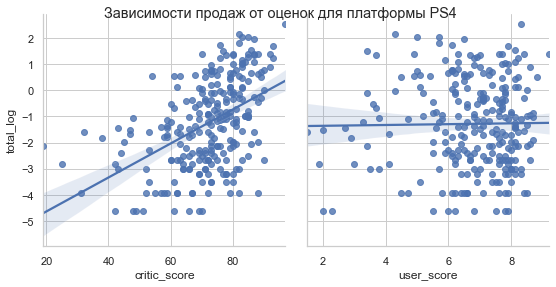

Коэффициент корреляции между оценками критиков и продажами для платформы PS4 составлявет 0.41
Коэффициент корреляции между оценками пользователей и продажами для платформы PS4 составлявет -0.03


In [58]:
cor_rating_sales('PS4')

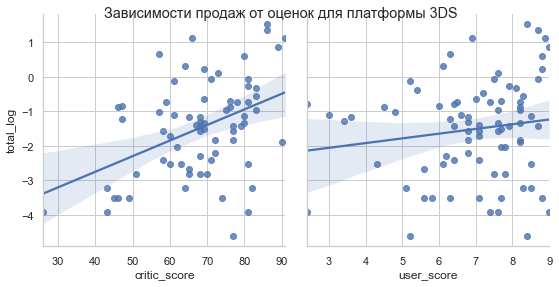

Коэффициент корреляции между оценками критиков и продажами для платформы 3DS составлявет 0.36
Коэффициент корреляции между оценками пользователей и продажами для платформы 3DS составлявет 0.24


In [59]:
cor_rating_sales('3DS')

Ну и старый добрый PC

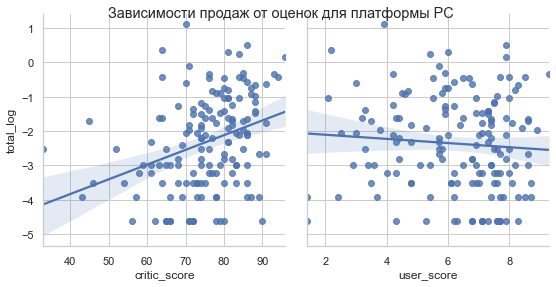

Коэффициент корреляции между оценками критиков и продажами для платформы PC составлявет 0.20
Коэффициент корреляции между оценками пользователей и продажами для платформы PC составлявет -0.09


In [60]:
cor_rating_sales('PC')

Можно сделать вывод, что оценка критиков коррелирует с продажами (хоть и не так выраженно), а вот оценки пользователей нет. Исключение является 3DS, у которой оценка пользователей коррелирует чуть больше по сравнению с другими.

#### 4.5. Распределение по жанрам <a id='analyze_genre'></a>

Построим две диаграммы распределения для жанров. По продажам и количеству игр

In [61]:
actual_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total,total_log
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.00,8.20,M,21.05,3.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.00,8.10,M,16.27,2.79
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,nan,nan,unc,14.63,2.68
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,nan,nan,unc,14.60,2.68
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.00,8.30,M,12.62,2.54


In [62]:
genre_pivot = actual_games.pivot_table(
    index='genre',
    values='total',
    aggfunc=['sum', 'count']
)
genre_pivot.columns = ['sales', 'count']
genre_pivot = genre_pivot.sort_values(by='sales', ascending=False)

In [63]:
genre_pivot

,sales,count
genre,,
Action,321.87,766
Shooter,232.98,187
Sports,150.65,214
Role-Playing,145.89,292
Misc,62.82,155
Platform,42.63,74
Racing,39.89,85
Fighting,35.31,80
Adventure,23.64,245


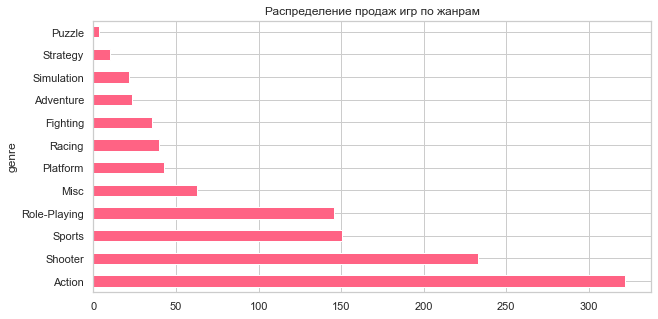

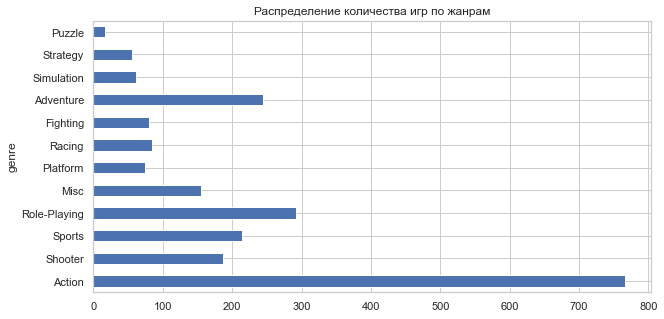

In [64]:
genre_pivot['sales'].plot(
    kind='barh',
    figsize=(10, 5),
    title = 'Распределение продаж игр по жанрам',
    color='#ff6384'
)
plt.show()
genre_pivot['count'].plot(
    kind='barh',
    figsize=(10, 5),
    title = 'Распределение количества игр по жанрам'
)
plt.show()

Судя по диаграммам жанр *Action* лидирует как по количеству выпускаемых игр так и по продажам. Далее следует *Shooter* и *Sport* . Это три самых продаваемых жанра. Но по количеству выпускаемых игр на третьем месте *Role-Playing*, *Adventure* на третьем. Самым не продаваемым жанром являются пазлы

### 5. Портрет пользователя по регионам <a id='portret'></a>

Определю для каждого региона самые популярные платформы (топ-5) и самые популярные жанры (топ-5).  
Также проверю влияние рейтинга ESRB на продажи в отдельном регионе.  
  
Для этого напишу функцию, которая на входе будет получать колонку с регионом, и выдавать будет вышеуказанные топы и влияние рейтинга на продажи.

In [65]:
def region_user(region):
    
    #создам переменную с наименование колонки которую буду использовать для тайтлов
    string = region
    
    #и переменную, чтобы понимать сколько букв нужно оставлять
    a = len(string) - 6
    
    #нахожу топ-5 платформ
    platforms = actual_games.pivot_table(
        index='platform',
        values=region,
        aggfunc='sum'
    ).sort_values(by=region, ascending=False).head()
    
    #нахожу топ-5 жанров
    genres = actual_games.pivot_table(
        index='genre',
        values=region,
        aggfunc='sum'
    ).sort_values(by=region, ascending=False).head()
    
    #нахожу продажи по рейтингу. также не беру в расчет unc
    rating_data = actual_games.loc[actual_games['rating'] != 'unc'].pivot_table(
        index='rating',
        values=region,
        aggfunc='sum'
    ).sort_values(by=region, ascending=False)
    
    #строю диаграммы
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
                 
    first = genres.plot(kind='bar', ax=ax1, rot=0, title='Топ-5 жанров для региона {}'.format(string[0:a]), color='#ff6384')
    second = platforms.plot(kind='bar', ax=ax2, rot=0, title='Топ-5 платформ для региона {}'.format(string[0:a]), color='#00a5ff')
    
    rating_data.plot(
        kind='bar',
        figsize=(13, 5),
        title = 'Продажи по рейтингу для региона {}'.format(string[0:a]),
        rot=0,
        color='#59d195'
    )
    plt.show()

А теперь выведем портрет для каждого региона

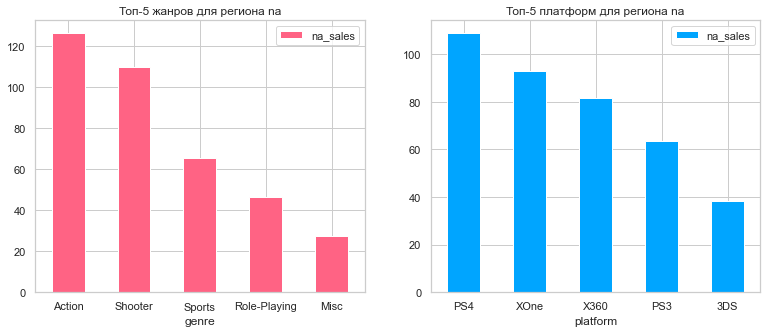

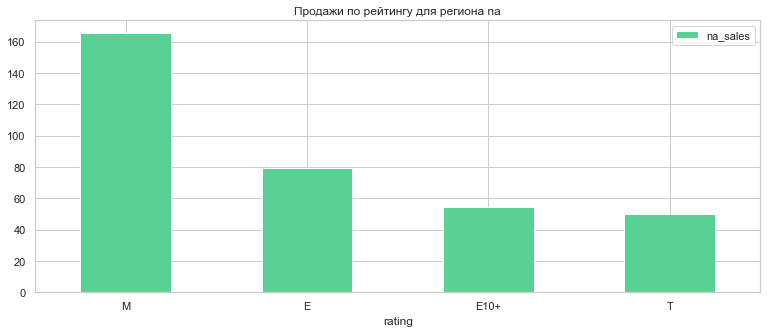

In [66]:
region_user('na_sales')

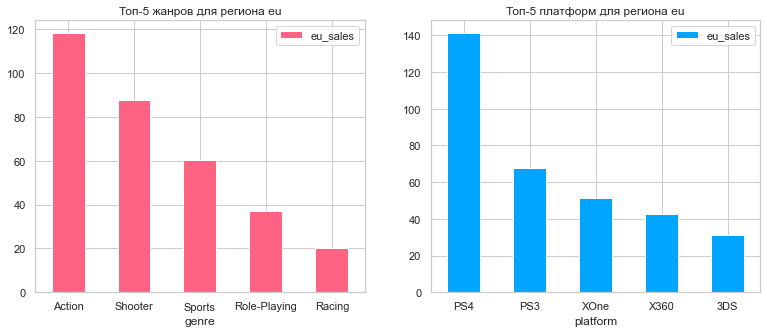

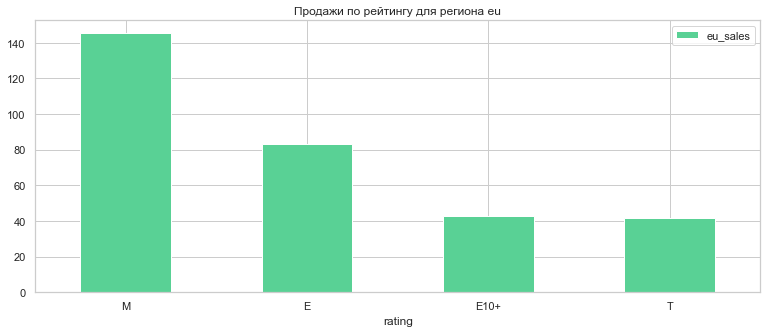

In [67]:
region_user('eu_sales')

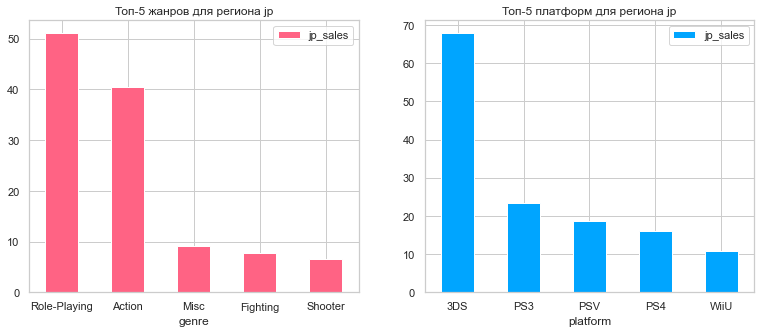

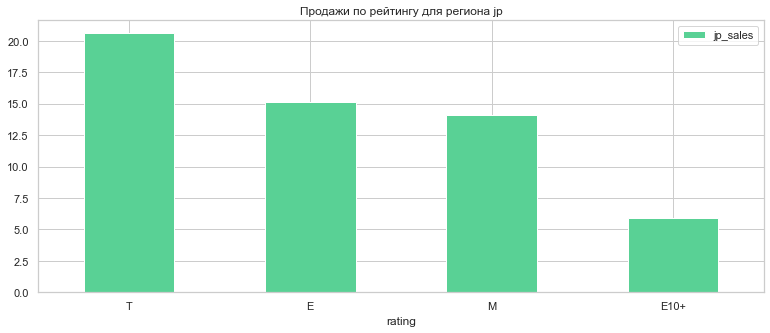

In [68]:
region_user('jp_sales')

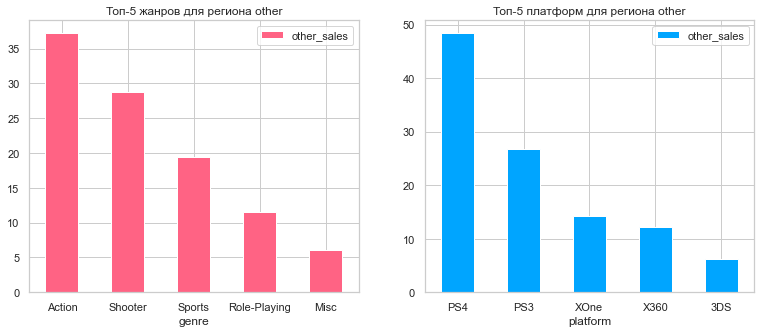

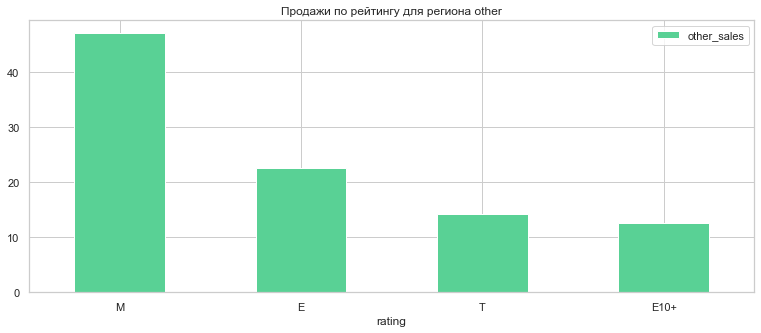

In [69]:
region_user('other_sales')

Как видно из диаграмм во всех регионах, за исключением Японии, преобладает *Action*, *Shooter* и *Sport*. Четвертые и пятые места уже имеют региональные предпочтения. Касательно Японии, то у нее на первом месте жанр *Role-Playing*, далее следует жанр *Action*, *Misc*, *Fighting* и *Shooter*.  
  
Если говорить о платформенных предпочтениях, то лидером в мире является PS4. Кроме Японии у которой это 3DS. XOne в Северной Америке проигрывает PS4, но не сильно. Но в других регионах последняя приставка от Microsoft вообще на третьем месте. 
  
Рейтинг игр не влияет на продажи в каком-то определенном регионе. Самыми продаваемыми являются игры с рейтингом M. Далее E. В Японии же игры с рейтингом T более продаваемы, чем с рейтингом M. Это может говорить о том, что в Японии игры предпочитают играть тинейджеры.

### 6. Проверка гипотез <a id='hypothesis'></a>

Имеются две гипотезы:  
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые  
2. Средние пользовательские рейтинги жанров Action и Sports разные  
  
Проверю их.

#### 6.1. Платформы Xbox One и PC <a id='hypothesis_platforms'></a>

Для начала сформулируем нулевую и альтернативную гипотезы:  
  
  1. Нулевая: *Средние пользовательские рейтинги платформ Xbox One и PC не отличаются*  
  2. Альтернативная: *Средние пользовательские рейтинги платформ Xbox One и PC не отличаются*  
  
Также стоит не забыть, что у нас имеются пропуски в оценках. Стоит их исключить

In [70]:
alpha = 0.05

result = st.ttest_ind(
    actual_games.loc[(actual_games['user_score'].notna()) & (actual_games['platform'] == 'PC')]['user_score'],
    actual_games.loc[(actual_games['user_score'].notna()) & (actual_games['platform'] == 'XOne')]['user_score']
                     )

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


Средние пользовательские рейтинги платформ Xbox One и PC не отличаются. Нулева гипотеза верна.

#### 6.2. Жанры Action и Sports <a id='hypothesis_genres'></a>

Сформулируем нулевую и альтернативную гипотезы:
    1. Нулевая: *средние пользовательские рейтинги жанров Action и Sports не отличаются*  
    2. Альтернативная: *средние пользовательские рейтинги жанров Action и Sports разные*  

In [71]:
alpha = 0.05

result = st.ttest_ind(
    actual_games.loc[(actual_games['user_score'].notna()) & (actual_games['genre'] == 'Action')]['user_score'],
    actual_games.loc[(actual_games['user_score'].notna()) & (actual_games['genre'] == 'Sports')]['user_score']
                     )

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


Тест показал, что вероятность получить подобные различия очень мала. Нулевая гипотеза отвергнута. Также построю диаграмму распределения, чтобы увидеть эти различия.

In [72]:
games_genre_a_and_s = actual_games.loc[
    (actual_games['user_score'].notna()) & ((actual_games['genre'] == 'Action') | (actual_games['genre'] == 'Sports'))]

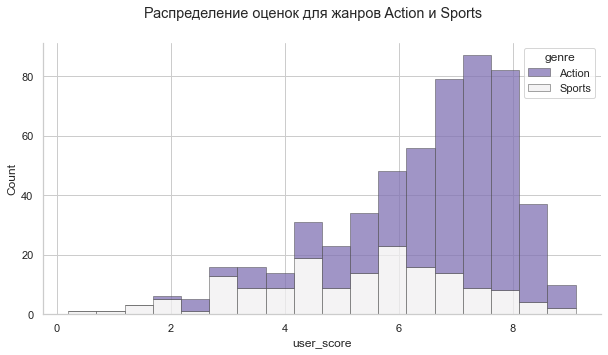

In [73]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)

plt.suptitle('Распределение оценок для жанров Action и Sports')

sns.histplot(
    games_genre_a_and_s,
    x='user_score', hue='genre',
    multiple='stack',
    palette='light:m_r',
    edgecolor='0.3',
    linewidth=.5
)
plt.show()

Как видно из распределения оценки пользователей для жанра *Sports* выше. Считаю эксперимент корректным.

### 7. Выводы и рекомендации <a id='conclusions'></a>

#### Выводы по обработке данных

Наименование колонок было привдено к нижнему регистру. Две игры без названия были удалены. Пропущенные годы были заполнены нулями и в анализе игнорировались. Пропущенные оценки критиков и пользователей были оставлены в формате nan. В статистическом тесте они игнорировались. Пропущенным рейтингам был присовоен класс unc. В исследовании он игнорировался.  
  
Разработчикам собиравшим данные необходимо направить выявленные пропуски для исправления в будущем.

#### Выводы по анализу

Игры были представлены за 37 лет. За 2016 год данные могли быть неполные, но считаю, что на результаты исследований это никак не повлияет. В целом наблюдается тенденция к сокращению выпуска игр. Пик на выпуск пришелся на 2008 и 2009 годы. Далее пошло на спад. Возможно, это связано с тем, что разработчики пытаются свои игры прорабатывать глубже и более детально, что увеличивает время выпуска.  
  
Пятью самыми успешными платформами по продажам игр являются PS2 с проданными 1,255.77 млн. копий, далее X360 с 971.42 млн.копий, PS3 - 939.65 млн. копий, Wii - 907.51 млн. копий и DS -	806.12 млн. копий.  
  
В среднем платформы живут 11 лет. Актуальные данные для прогноза на будущее были взяты за 4 года до прогнозируемого года.

#### Рекомендации

Старые популярные платформы X360 и PS3 постепенно перестают быть популярными. Они находятся на закате своего жизненного цикла. На смену им приходят XOne и PS4. Следует уделить внимание этим платформам. PC как платформа для игр очень долгоживущая, связано это с возможностью апгрейда устройства, что позволяет играть современные ресурсные игры. В ближайшее время эта платформа тоже будет иметь своих пользователей. Платформы от Nintendo такие как 3DS и Wii также являются популярными. Но жизненный цикл Wii уже подходит к концу, а вот 3DS еще года 3 будет популярной.

#### Портрет пользователя

В целом предпочтения пользователей во всех регионах кроме Японии схожи. Существуют небольшие различия по приставкам и жанрам. Но топ-3 жанра неизменны. Это *Action*, *Shooter* и *Sport*.  
  
Лидером среди платформ в мире является PS4. Кроме Японии у которой это 3DS. XOne в Северной Америке проигрывает PS4, но не сильно. Но в других регионах последняя приставка от Microsoft вообще на третьем месте.

#### Выводы по проверке гипотез

Проверка первой гипотезы показала что средние пользовательские рейтинги платформ Xbox One и PC.
  
Проверка второй гипотезы показала, что оценки пользователей для жанра *Sports* и *Action* отличаются.